# Music Composer Classification
* Github: https://github.com/birendrakhimding/Music-Composer-Classification

# LSTM Model

## Importing Libraries and Setup
Importing necessary libraries for MIDI processing, machine learning, and visualization. Setting up the environment for reproducible results.

*   Refrence : https://app.readytensor.ai/publications/music-composer-classification-of-midi-files-using-deep-learning-qZ9m02sVKl8C


In [1]:
import os
import numpy as np
import pandas as pd
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

ModuleNotFoundError: No module named 'pretty_midi'

## Setting Random Seed
Ensuring reproducible results by setting random seeds for all libraries.


In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Defining Feature Extraction Function
Defining a function to extract musical features from MIDI files including tempo, pitch variance, velocity, polyphony, and rhythmic characteristics. These features capture the distinctive musical style of each composer.


In [ ]:
def extract_features(midi_path):
    # Load the MIDI file using pretty_midi
    midi = pretty_midi.PrettyMIDI(midi_path)

    # Estimate the overall tempo (beats per minute)
    tempo = midi.estimate_tempo()

    # Collect all notes from non-drum instruments
    notes = []
    for inst in midi.instruments:
        if not inst.is_drum:
            notes.extend(inst.notes)
    if not notes:
        return None

    # Sort notes by their start time
    notes = sorted(notes, key=lambda x: x.start)

    # Calculate the total duration of the piece
    duration = midi.get_end_time()

     # Note density: number of notes per second
    note_density = len(notes) / duration if duration > 0 else 0

     # Pitch variance: how spread out the pitches are
    pitches = np.array([note.pitch for note in notes])
    pitch_variance = np.var(pitches)

    # Velocity features: how hard notes are played
    velocities = np.array([note.velocity for note in notes])
    velocity_mean = np.mean(velocities)
    velocity_max = np.max(velocities)
    velocity_var = np.var(velocities)

     # Polyphony: average number of notes sounding at the same time
    fs = 100
    piano_roll = midi.get_piano_roll(fs=fs)
    polyphony = np.mean(np.sum(piano_roll > 0, axis=0))

    # Rhythmic density: similar to note density (could later be refined)
    rhythmic_density = len(notes) / duration if duration > 0 else 0

    # Average pitch interval: average jump between consecutive notes
    pitch_intervals = np.abs(np.diff(pitches))
    avg_pitch_interval = np.mean(pitch_intervals) if len(pitch_intervals) > 0 else 0

    # Chord density: proportion of notes that start almost at the same time (within 50 ms)
    chord_counts = sum(1 for i in range(len(notes)-1) if abs(notes[i+1].start - notes[i].start) < 0.05)
    chord_density = chord_counts / len(notes)

    # Pitch transitions: ratio of changes in pitch from one note to the next
    pitch_transitions = np.sum(pitches[1:] != pitches[:-1]) / len(pitches) if len(pitches) > 1 else 0

     # Average note duration
    durations = np.array([note.end - note.start for note in notes])
    avg_note_duration = np.mean(durations)

     # Number of instruments used
    num_instrument = len(midi.instruments)

    return {
        "tempo": tempo,
        "note_density": note_density,
        "pitch_variance": pitch_variance,
        "velocity_mean": velocity_mean,
        "velocity_max": velocity_max,
        "velocity_variance": velocity_var,
        "polyphony": polyphony,
        "rhythmic_density": rhythmic_density,
        "avg_pitch_interval": avg_pitch_interval,
        "chord_density": chord_density,
        "pitch_transitions": pitch_transitions,
        "avg_note_duration": avg_note_duration,
        "num_instrument": num_instrument
    }

## Exploratory Data Analysis
Visualizing the distribution of musical features across different composers to understand the data and identify patterns that distinguish composers.


In [ ]:
# Initialize empty lists to store features and corresponding labels
data = []
labels = []

# Define the dataset splits (train and test)
split_dr = ['train', 'test']

# Loop through each split (train/test folders) and process the MIDI files
for split in split_dr:
    split_path = os.path.join('musicData', split)
    for composer in os.listdir(split_path):
        if composer.endswith(".DS_Store"):
            continue
        composer_path = os.path.join(split_path, composer)
        for file in os.listdir(composer_path):
            if file.endswith(".DS_Store"):
                continue
            if file.endswith('.mid'):
                file_path = os.path.join(composer_path, file)
                 # Extract features from the MIDI file
                features = extract_features(file_path)
                if features is not None:
                    data.append(features)
                    labels.append(composer)

# Convert to DataFrame
df = pd.DataFrame(data)
df['composer'] = labels

/opt/homebrew/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


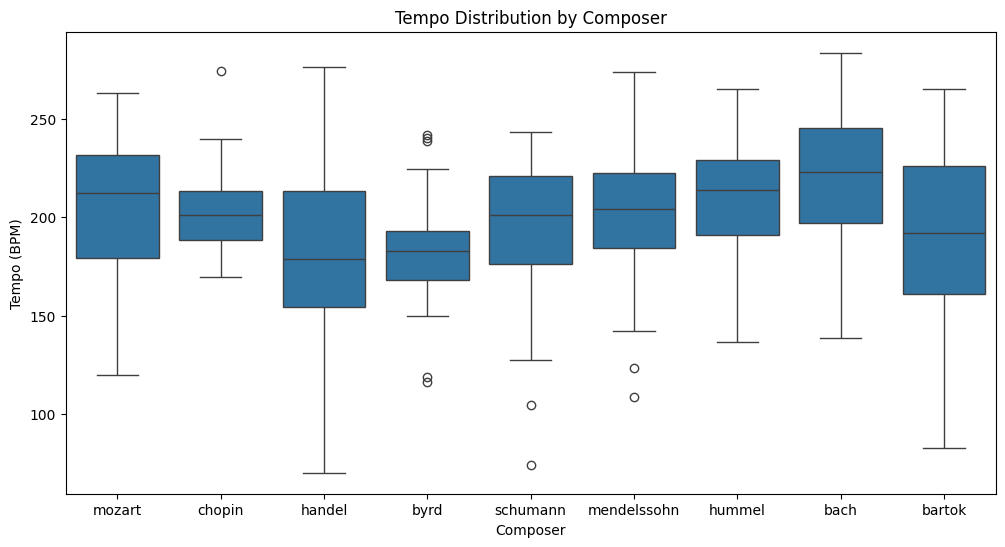

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='composer', y='tempo', data=df)
plt.title('Tempo Distribution by Composer')
plt.ylabel('Tempo (BPM)')
plt.xlabel('Composer')
plt.show()

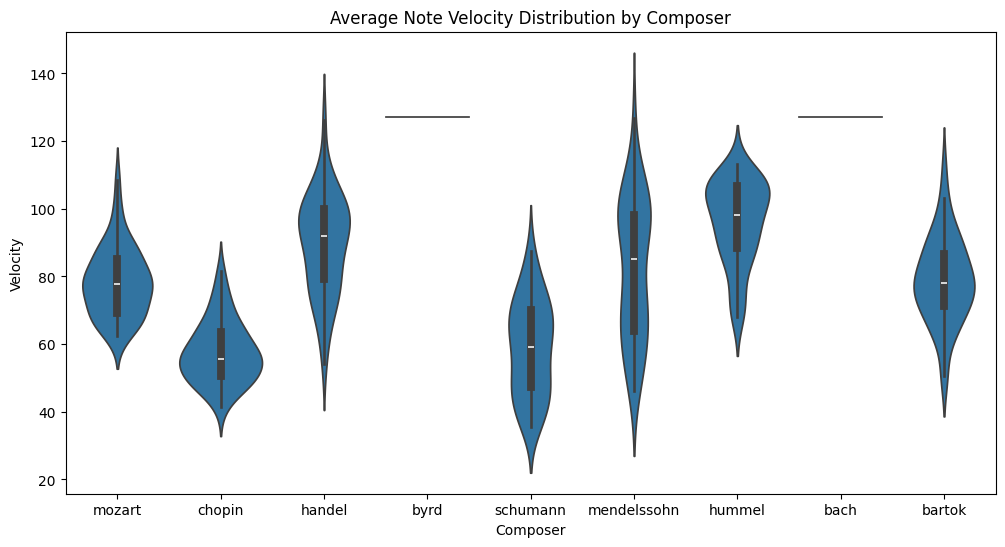

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='composer', y='velocity_mean', data=df)
plt.title('Average Note Velocity Distribution by Composer')
plt.ylabel('Velocity')
plt.xlabel('Composer')
plt.show()

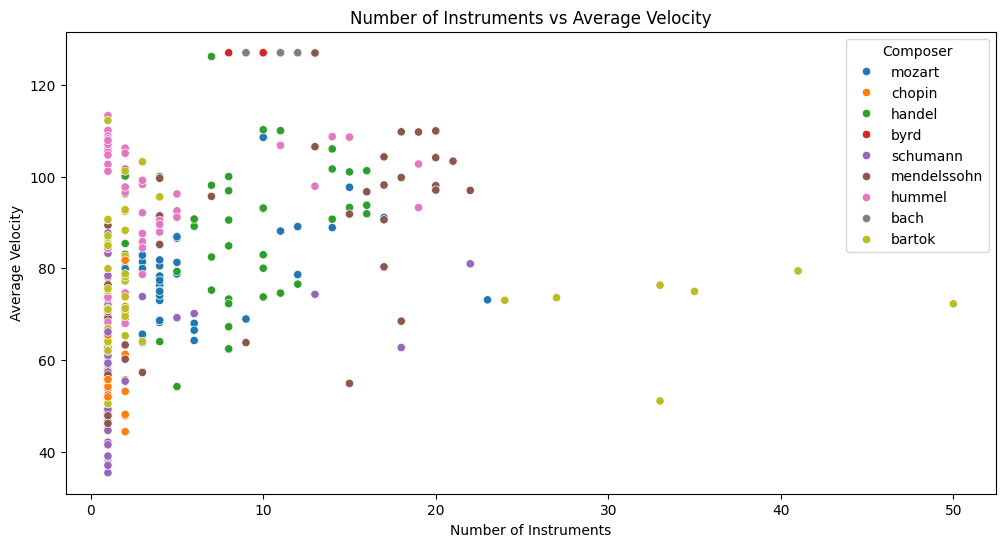

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='num_instrument', y='velocity_mean', hue='composer', data=df)
plt.title('Number of Instruments vs Average Velocity')
plt.ylabel('Average Velocity')
plt.xlabel('Number of Instruments')
plt.legend(title='Composer')
plt.show()

## Analyzing Class Distribution
Visualizing the number of samples per composer to understand dataset balance and identify potential class imbalance issues.


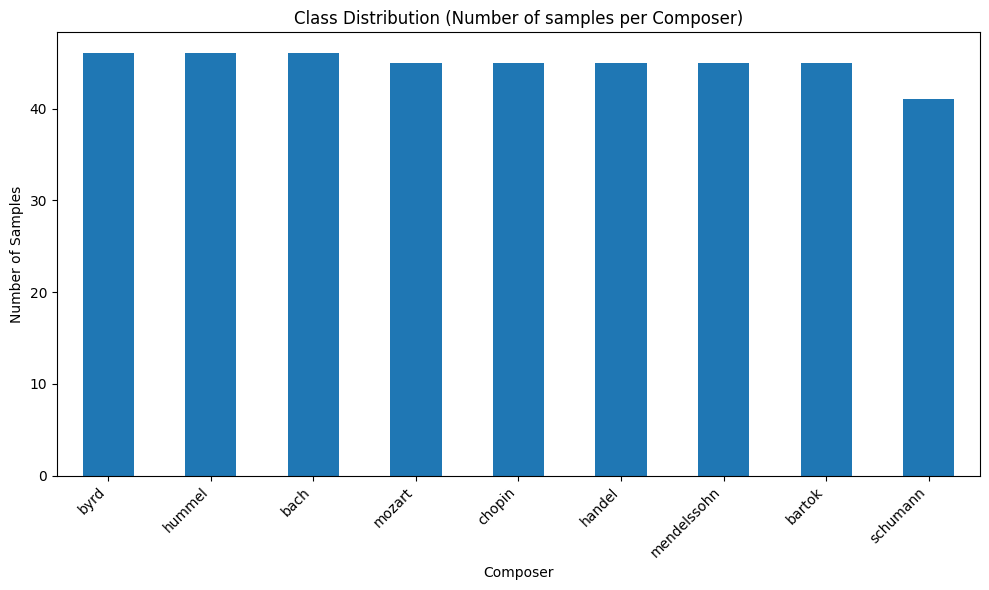

In [ ]:
# Count samples per composer
class_counts = df['composer'].value_counts()

# Plot bar chart
plt.figure(figsize=(10,6))
class_counts.plot(kind='bar')
plt.title('Class Distribution (Number of samples per Composer)')
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing Data
Encoding composer labels and normalizing features to prepare the data for machine learning. StandardScaler ensures all features contribute equally to model training.

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['composer'])

# Separate features and scale them
X = df.drop('composer', axis=1).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Creating Sequences for LSTM
Creating time sequences from the feature data since LSTM networks require sequential input. Each sequence captures temporal patterns that help distinguish composer styles.

In [ ]:
# Create sequences for LSTM (sequence length = 5)
seq_length = 10
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length-1])  # label of last timestep in sequence
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_length)


### Splitting Train-Test Data
Splitting the sequential data into training and testing sets while maintaining class distribution using stratification.

In [ ]:
# Train-test split with stratification
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

### Encoding One-Hot Labels
Converting categorical composer labels into one-hot encoded format for multi-class classification with neural networks.


In [ ]:
# One-hot encode targets
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_seq, num_classes)
y_test_cat = to_categorical(y_test_seq, num_classes)

## Building and Training LSTM Model
Constructing a sequential LSTM network with dropout and batch normalization. Training the model with early stopping and learning rate reduction to classify composer styles.


In [ ]:
# Define model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
model = Sequential([
    LSTM(15, return_sequences=True, input_shape=input_shape, recurrent_dropout=0.4),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(5, recurrent_dropout=0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

# Compile Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# Train model
history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, lr_reduce],
    verbose=0
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

3/3 [==============================] - 0s 2ms/step - loss: 0.5481 - accuracy: 0.8861
Test Accuracy: 0.8861


## Visualizing Training History
Plotting training and validation accuracy and loss curves to analyze model performance and detect overfitting.


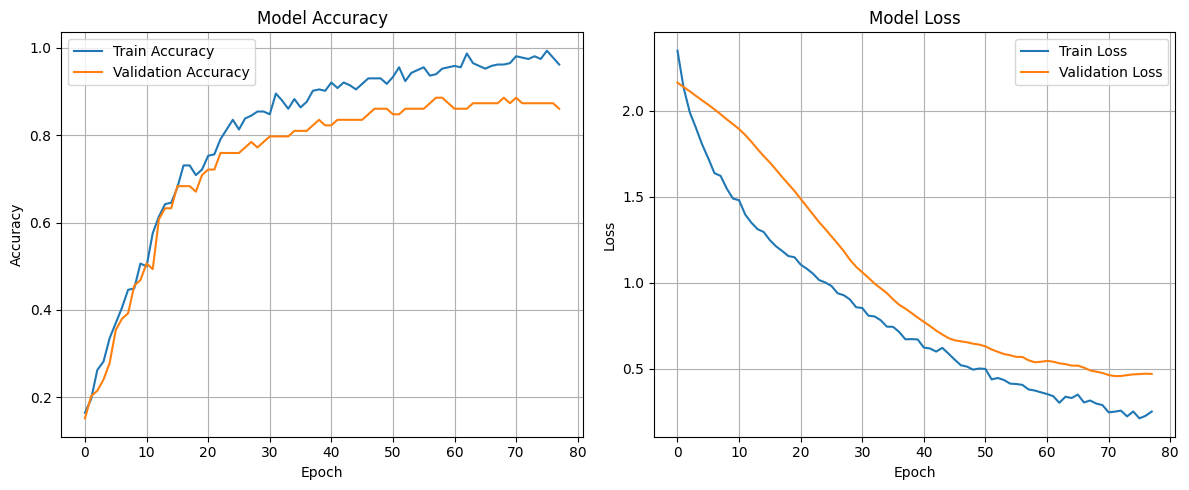

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluating Model Performance
Generating detailed classification report with precision, recall, and F1-scores for each composer to assess model effectiveness.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test_seq)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels (already integer encoded)
y_true = y_test_seq

# Print classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        bach       1.00      0.89      0.94         9
      bartok       0.82      1.00      0.90         9
        byrd       1.00      0.78      0.88         9
      chopin       0.88      0.78      0.82         9
      handel       0.80      0.89      0.84         9
      hummel       0.90      0.90      0.90        10
 mendelssohn       0.90      1.00      0.95         9
      mozart       0.71      0.71      0.71         7
    schumann       1.00      1.00      1.00         8

    accuracy                           0.89        79
   macro avg       0.89      0.88      0.88        79
weighted avg       0.89      0.89      0.89        79



### Confusion Matrix Analysis
Creating a confusion matrix to visualize which composers are most commonly confused with each other, helping identify classification patterns and potential similarities between composer styles.


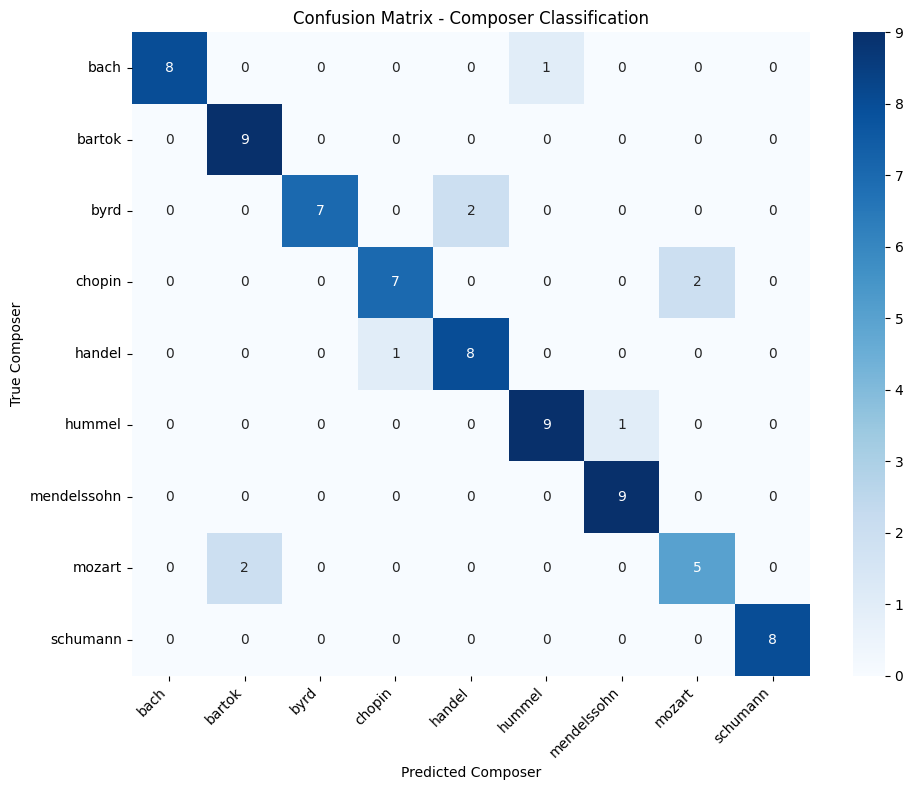


Per-Class Accuracy:
bach: 0.889
bartok: 1.000
byrd: 0.778
chopin: 0.778
handel: 0.889
hummel: 0.900
mendelssohn: 1.000
mozart: 0.714
schumann: 1.000


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Composer Classification')
plt.ylabel('True Composer')
plt.xlabel('Predicted Composer')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate and display per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, composer in enumerate(label_encoder.classes_):
    print(f"{composer}: {per_class_accuracy[i]:.3f}")


### Prediction Confidence Analysis
Analyzing the model's confidence in its predictions to understand when the model is most and least certain about composer classification.


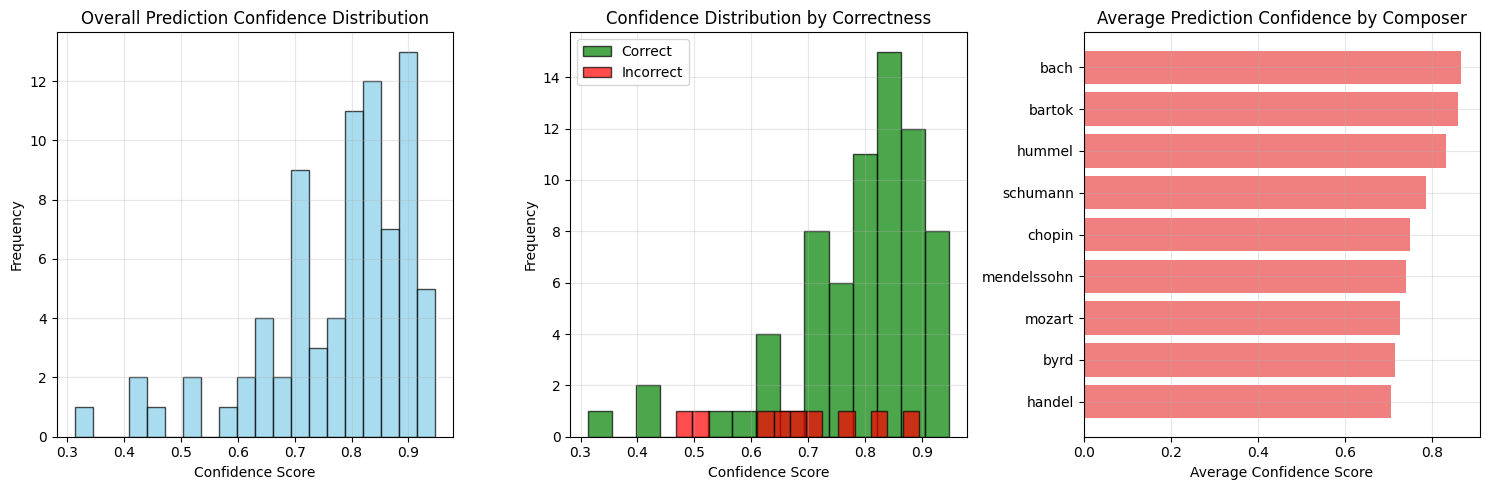

Overall average confidence: 0.778
Average confidence for correct predictions: 0.791
Average confidence for incorrect predictions: 0.681
Confidence difference: 0.110


In [ ]:
# Calculate prediction confidence (max probability for each prediction)
prediction_confidence = np.max(y_pred_probs, axis=1)

# Create a DataFrame for easier analysis
pred_df = pd.DataFrame({
    'true_composer': [label_encoder.classes_[i] for i in y_true],
    'predicted_composer': [label_encoder.classes_[i] for i in y_pred],
    'confidence': prediction_confidence,
    'correct': y_true == y_pred
})

# Plot confidence distribution
plt.figure(figsize=(15, 5))

# Overall confidence distribution
plt.subplot(1, 3, 1)
plt.hist(prediction_confidence, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Overall Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Confidence by correctness
plt.subplot(1, 3, 2)
correct_conf = pred_df[pred_df['correct']]['confidence']
incorrect_conf = pred_df[~pred_df['correct']]['confidence']

plt.hist(correct_conf, bins=15, alpha=0.7, label='Correct', color='green', edgecolor='black')
plt.hist(incorrect_conf, bins=15, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
plt.title('Confidence Distribution by Correctness')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Average confidence by composer
plt.subplot(1, 3, 3)
avg_confidence = pred_df.groupby('true_composer')['confidence'].mean().sort_values(ascending=True)
plt.barh(range(len(avg_confidence)), avg_confidence.values, color='lightcoral')
plt.yticks(range(len(avg_confidence)), avg_confidence.index)
plt.title('Average Prediction Confidence by Composer')
plt.xlabel('Average Confidence Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Overall average confidence: {np.mean(prediction_confidence):.3f}")
print(f"Average confidence for correct predictions: {np.mean(correct_conf):.3f}")
print(f"Average confidence for incorrect predictions: {np.mean(incorrect_conf):.3f}")
print(f"Confidence difference: {np.mean(correct_conf) - np.mean(incorrect_conf):.3f}")


## Detailed Per-Class Performance Metrics
Visualizing precision, recall, and F1-scores for each composer to identify which composers are classified most accurately and which need improvement.


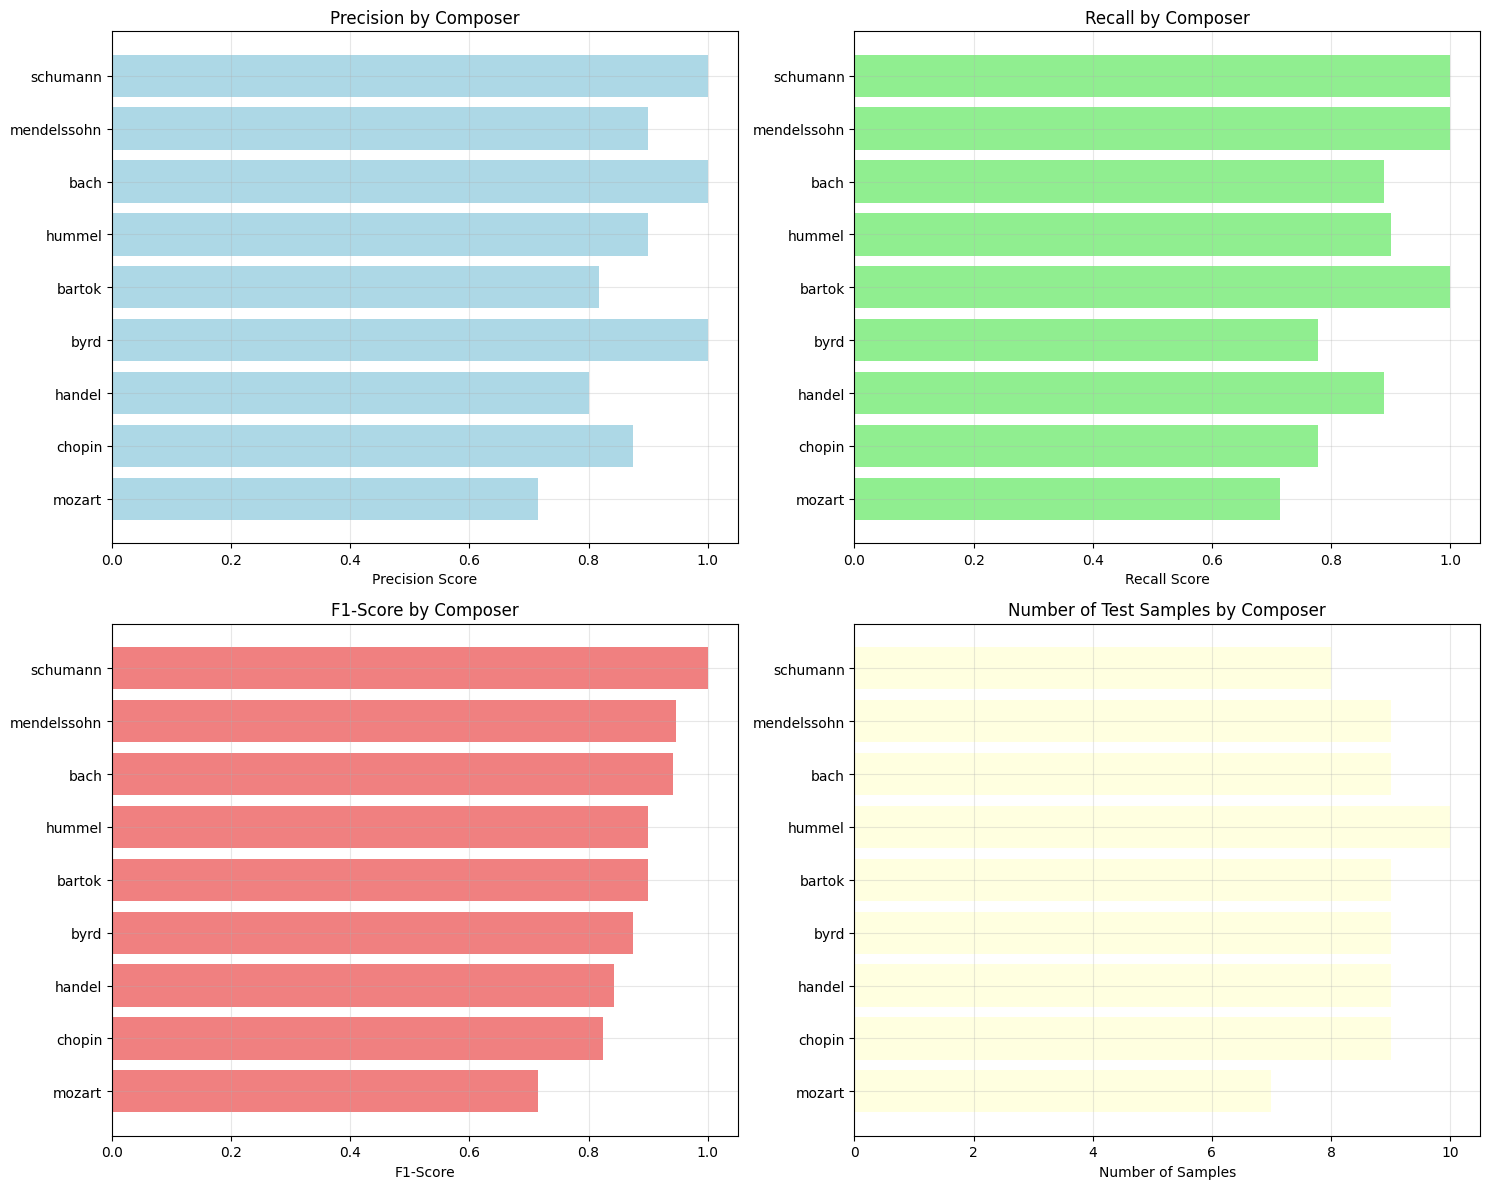

Detailed Performance Metrics:
   Composer  Precision  Recall  F1-Score  Support
     mozart      0.714   0.714     0.714        7
     chopin      0.875   0.778     0.824        9
     handel      0.800   0.889     0.842        9
       byrd      1.000   0.778     0.875        9
     bartok      0.818   1.000     0.900        9
     hummel      0.900   0.900     0.900       10
       bach      1.000   0.889     0.941        9
mendelssohn      0.900   1.000     0.947        9
   schumann      1.000   1.000     1.000        8

Best performing composer (F1-Score): schumann (1.000)
Worst performing composer (F1-Score): mozart (0.714)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate detailed metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Composer': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Sort by F1-score for better visualization
metrics_df = metrics_df.sort_values('F1-Score', ascending=True)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Precision
axes[0, 0].barh(metrics_df['Composer'], metrics_df['Precision'], color='lightblue')
axes[0, 0].set_title('Precision by Composer')
axes[0, 0].set_xlabel('Precision Score')
axes[0, 0].grid(True, alpha=0.3)

# Recall
axes[0, 1].barh(metrics_df['Composer'], metrics_df['Recall'], color='lightgreen')
axes[0, 1].set_title('Recall by Composer')
axes[0, 1].set_xlabel('Recall Score')
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[1, 0].barh(metrics_df['Composer'], metrics_df['F1-Score'], color='lightcoral')
axes[1, 0].set_title('F1-Score by Composer')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].grid(True, alpha=0.3)

# Support (number of samples)
axes[1, 1].barh(metrics_df['Composer'], metrics_df['Support'], color='lightyellow')
axes[1, 1].set_title('Number of Test Samples by Composer')
axes[1, 1].set_xlabel('Number of Samples')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display metrics table
print("Detailed Performance Metrics:")
print(metrics_df.round(3).to_string(index=False))

# Show best and worst performers
print(f"\nBest performing composer (F1-Score): {metrics_df.iloc[-1]['Composer']} ({metrics_df.iloc[-1]['F1-Score']:.3f})")
print(f"Worst performing composer (F1-Score): {metrics_df.iloc[0]['Composer']} ({metrics_df.iloc[0]['F1-Score']:.3f})")


### Composer Similarity Visualization (t-SNE)
Using t-SNE dimensionality reduction to visualize how similar composers are in the feature space, helping understand which composers have similar musical characteristics.


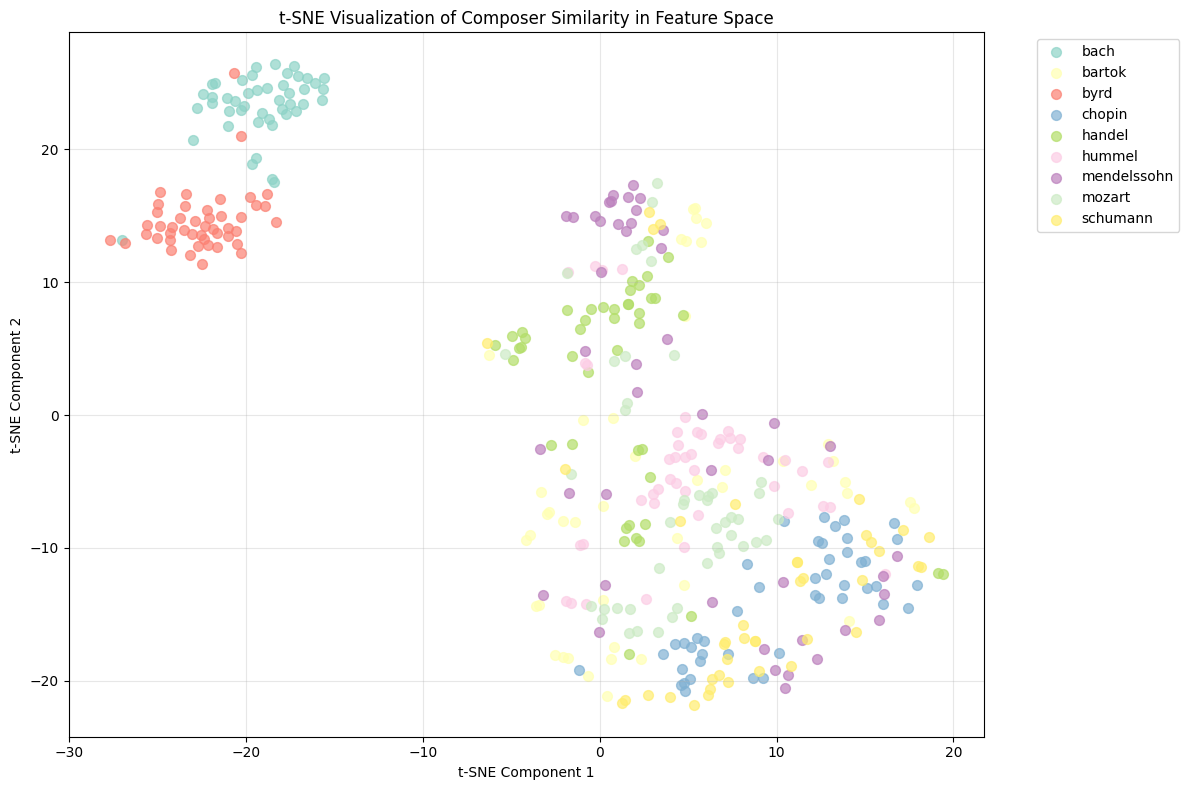

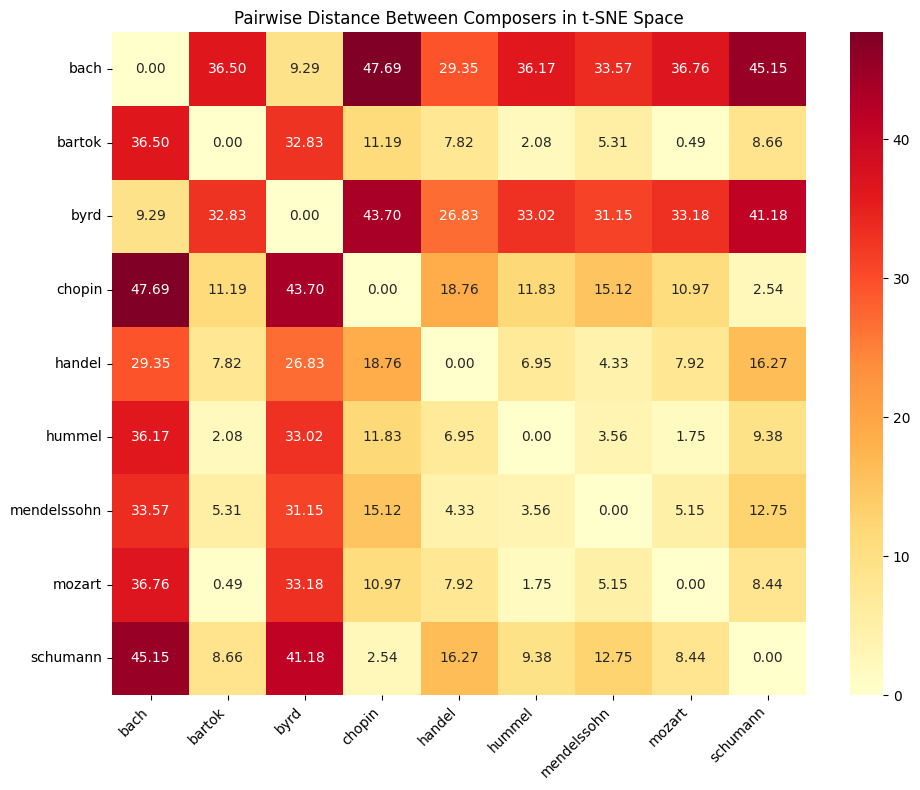

Interpretation:
- Closer points in t-SNE plot indicate more similar musical features
- Lower values in distance matrix indicate more similar composers
- Clusters in the t-SNE plot suggest groups of composers with similar styles


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

# Use the original scaled features (not sequences) for better visualization
# Take a sample for t-SNE (t-SNE can be computationally expensive)
sample_size = min(500, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]
y_sample = y[sample_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

# Create color map for composers
colors = plt.cm.Set3(np.linspace(0, 1, len(label_encoder.classes_)))
composer_colors = {composer: colors[i] for i, composer in enumerate(label_encoder.classes_)}

# Plot t-SNE results
plt.figure(figsize=(12, 8))
for i, composer in enumerate(label_encoder.classes_):
    mask = y_sample == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=[composer_colors[composer]],
               label=composer, alpha=0.7, s=50)

plt.title('t-SNE Visualization of Composer Similarity in Feature Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate pairwise distances between composer centroids in t-SNE space
composer_centroids = {}
for i, composer in enumerate(label_encoder.classes_):
    mask = y_sample == i
    if np.sum(mask) > 0:  # Check if composer has samples
        centroid = np.mean(X_tsne[mask], axis=0)
        composer_centroids[composer] = centroid

# Create distance matrix between composers
composer_names = list(composer_centroids.keys())
n_composers = len(composer_names)
distance_matrix = np.zeros((n_composers, n_composers))

for i, comp1 in enumerate(composer_names):
    for j, comp2 in enumerate(composer_names):
        if comp1 in composer_centroids and comp2 in composer_centroids:
            distance = np.linalg.norm(composer_centroids[comp1] - composer_centroids[comp2])
            distance_matrix[i, j] = distance

# Plot distance heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=composer_names, yticklabels=composer_names)
plt.title('Pairwise Distance Between Composers in t-SNE Space')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Closer points in t-SNE plot indicate more similar musical features")
print("- Lower values in distance matrix indicate more similar composers")
print("- Clusters in the t-SNE plot suggest groups of composers with similar styles")


### Feature Importance Analysis
Analyzing which musical features are most important for distinguishing between composers using correlation analysis and feature variance across composers.


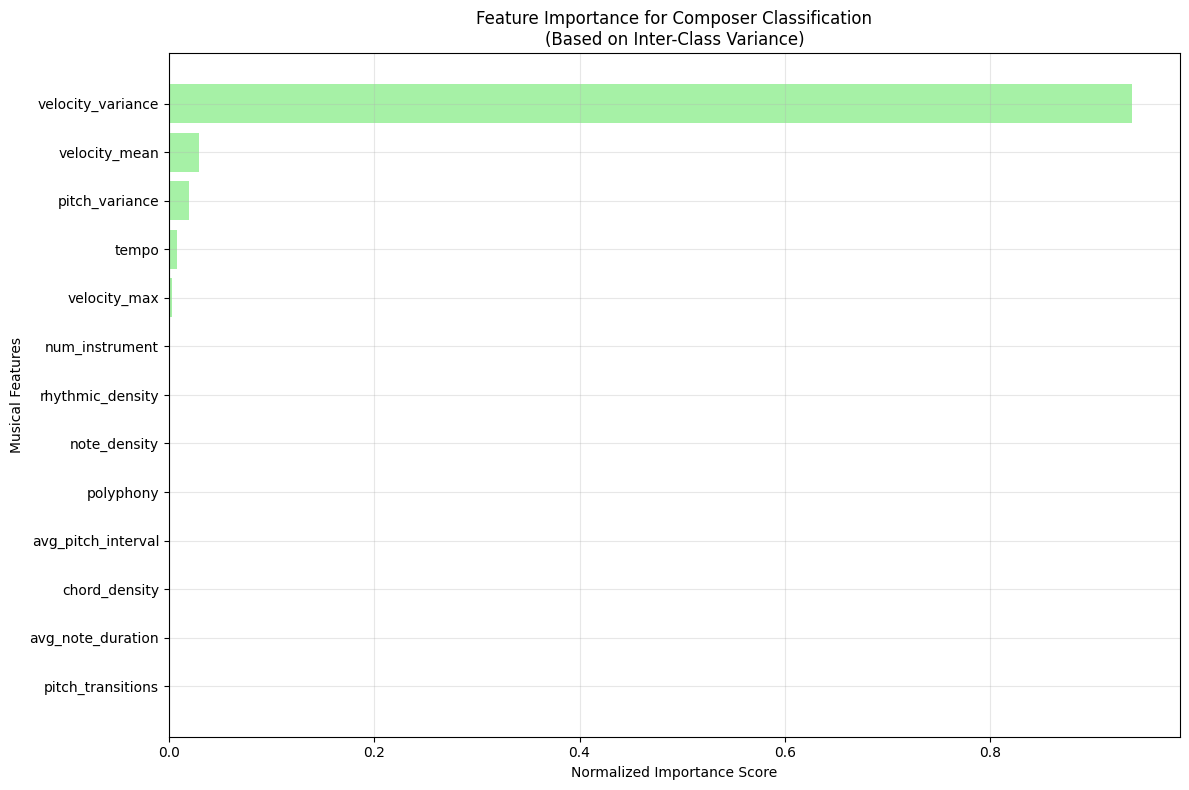

Top 5 Most Important Features:
1. velocity_max: 0.0028
2. tempo: 0.0079
3. pitch_variance: 0.0197
4. velocity_mean: 0.0296
5. velocity_variance: 0.9381


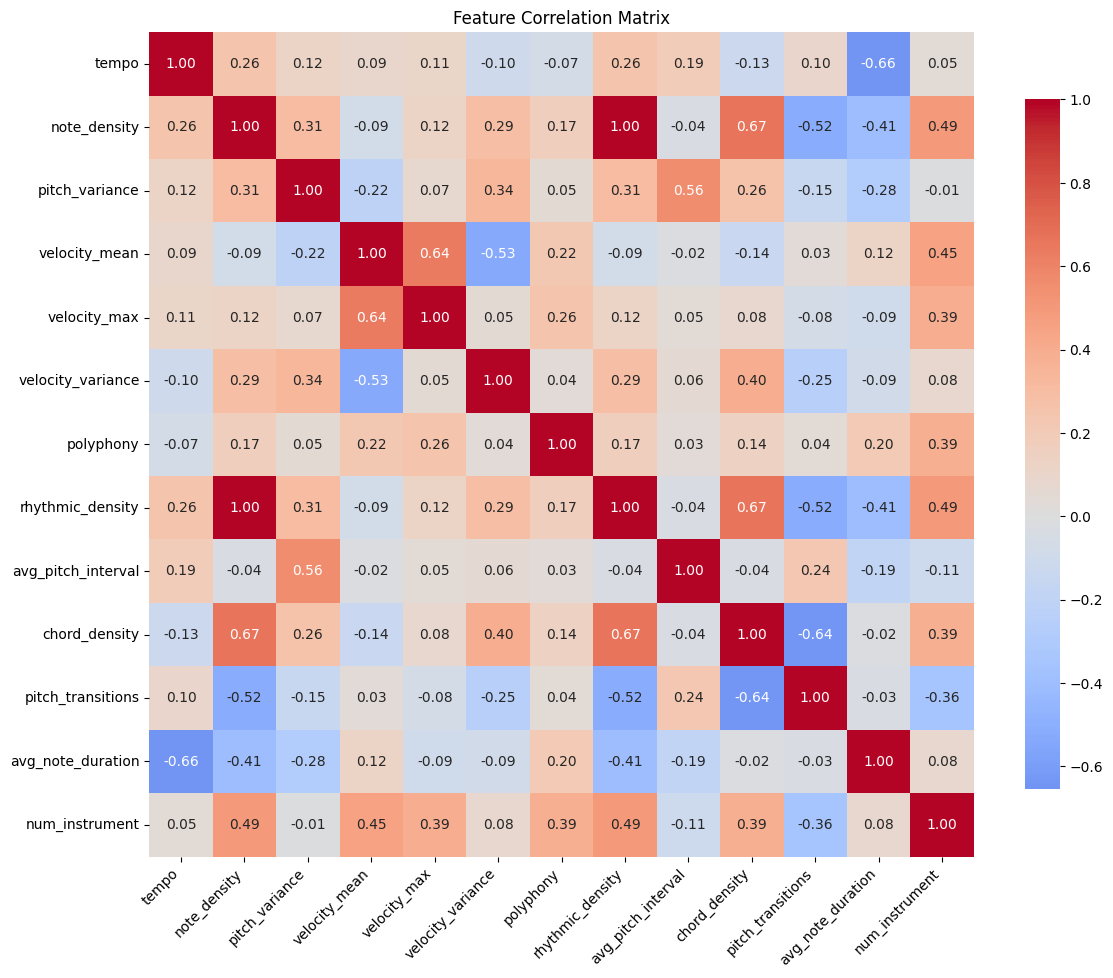

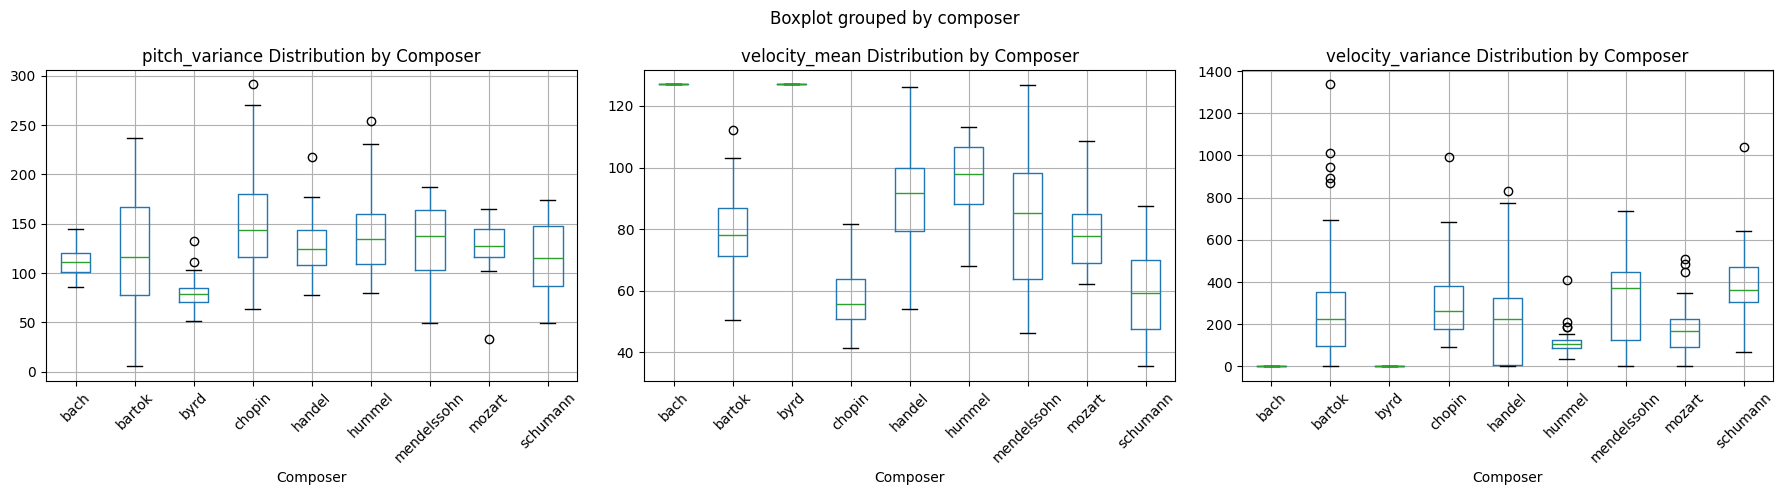


Feature Analysis Summary:
Most discriminative feature: velocity_variance
Least discriminative feature: pitch_transitions
Total features analyzed: 13


In [ ]:
# Feature names
feature_names = ['tempo', 'note_density', 'pitch_variance', 'velocity_mean',
                'velocity_max', 'velocity_variance', 'polyphony', 'rhythmic_density',
                'avg_pitch_interval', 'chord_density', 'pitch_transitions',
                'avg_note_duration', 'num_instrument']

# Calculate feature importance using inter-class variance
feature_importance = []
for i, feature_name in enumerate(feature_names):
    # Get feature values for each composer
    composer_means = []
    for composer in label_encoder.classes_:
        composer_mask = df['composer'] == composer
        composer_mean = df[composer_mask].iloc[:, i].mean()
        composer_means.append(composer_mean)

    # Calculate variance between composer means (higher variance = more discriminative)
    inter_class_variance = np.var(composer_means)
    feature_importance.append(inter_class_variance)

# Normalize importance scores
feature_importance = np.array(feature_importance)
feature_importance_normalized = feature_importance / np.sum(feature_importance)

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_normalized,
    'Raw_Variance': feature_importance
}).sort_values('Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen', alpha=0.8)
plt.title('Feature Importance for Composer Classification\n(Based on Inter-Class Variance)')
plt.xlabel('Normalized Importance Score')
plt.ylabel('Musical Features')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show top 5 most important features
print("Top 5 Most Important Features:")
for i, (_, row) in enumerate(importance_df.tail(5).iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Importance']:.4f}")

# Create feature correlation heatmap
plt.figure(figsize=(12, 10))
feature_data = df.drop('composer', axis=1)
correlation_matrix = feature_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show feature statistics by composer for top 3 features
top_features = importance_df.tail(3)['Feature'].values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_features):
    df.boxplot(column=feature, by='composer', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Composer')
    axes[i].set_xlabel('Composer')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nFeature Analysis Summary:")
print(f"Most discriminative feature: {importance_df.iloc[-1]['Feature']}")
print(f"Least discriminative feature: {importance_df.iloc[0]['Feature']}")
print(f"Total features analyzed: {len(feature_names)}")


# CNN Model
## Importing Libraries and Setup
Importing necessary libraries for MIDI processing, machine learning, and visualization.

In [24]:

#!unzip -q "Composer_Dataset.zip"
#!pip install pretty_midi librosa music21

In [33]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MIDI processing
import pretty_midi

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D,
    Dense, Dropout, Flatten, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.utils import to_categorical  # For one-hot encoding if needed
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report

# Enable mixed precision for faster training on supported GPUs
mixed_precision.set_global_policy('mixed_float16')
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                     MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense)
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, classification_report


## Utilities

In [3]:
# ---------- Plot helpers ----------
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(12,4))
    # acc
    plt.subplot(1,2,1)
    plt.plot(history.history.get('accuracy', []), label='train')
    plt.plot(history.history.get('val_accuracy', []), label='val')
    plt.title(f'{title_prefix} Accuracy'); plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.grid(alpha=.3)
    # loss
    plt.subplot(1,2,2)
    plt.plot(history.history.get('loss', []), label='train')
    plt.plot(history.history.get('val_loss', []), label='val')
    plt.title(f'{title_prefix} Loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(alpha=.3)
    plt.tight_layout(); plt.show()

def plot_confusion_simple(y_true, y_pred, label_map, normalize=True, title="Confusion Matrix"):
    names = list(label_map.keys())
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(names))))
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
    plt.figure(figsize=(6.5,5.5))
    plt.imshow(cm, aspect='auto'); plt.colorbar(label='Prop' if normalize else 'Count')
    plt.xticks(range(len(names)), names, rotation=45, ha='right'); plt.yticks(range(len(names)), names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i,j]:.2f}" if normalize else f"{int(cm[i,j])}"
            plt.text(j, i, txt, ha='center', va='center', fontsize=8)
    plt.tight_layout(); plt.show()

In [4]:


def get_fixed_piano_roll(midi_path, fs=25, max_time_steps=1200, binarize=True, velocity_clip=127):
    """
    Convert a MIDI file to a fixed-size piano roll (128 x max_time_steps).
    - Align earliest note to t=0
    - Clip velocities to `velocity_clip`
    - Pad/truncate to fixed length
    - Optionally binarize (0/1)
    """
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)

        # Align start to t=0
        starts = [n.start for inst in pm.instruments for n in inst.notes]
        if starts:
            shift = min(starts)
            if shift > 0:
                for inst in pm.instruments:
                    for n in inst.notes:
                        n.start -= shift
                        n.end   -= shift

        # Get piano roll
        roll = pm.get_piano_roll(fs=fs)[:128, :]
        roll = np.clip(roll, 0, velocity_clip) / float(velocity_clip)

        # Pad/truncate
        if roll.shape[1] < max_time_steps:
            pad = max_time_steps - roll.shape[1]
            roll = np.pad(roll, ((0,0),(0,pad)), mode='constant')
        else:
            roll = roll[:, :max_time_steps]

        if binarize:
            roll = (roll > 0).astype(np.float32)
        else:
            roll = roll.astype(np.float32)

        return roll
    except Exception as e:
        print(f"Skipped {midi_path}: {e}")
        return None


# 1. Data Collection

In [5]:
def process_and_save_all(mid_root, save_dir, csv_path):
    os.makedirs(save_dir, exist_ok=True)
    rows = []
    for composer in sorted(os.listdir(mid_root)):
        comp_dir = os.path.join(mid_root, composer)
        if not os.path.isdir(comp_dir):
            continue
        for fname in os.listdir(comp_dir):
            if not fname.lower().endswith(('.mid','.midi')):
                continue
            full_path = os.path.join(comp_dir, fname)
            roll = get_fixed_piano_roll(full_path, fs=25, max_time_steps=1200)
            if roll is None:
                continue
            save_name = f"{composer}_{os.path.splitext(fname)[0]}.npy"
            save_path = os.path.join(save_dir, save_name)
            np.save(save_path, roll)
            rows.append([save_path, composer])
    df = pd.DataFrame(rows, columns=["file_path","label"])
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} files to {save_dir}")
    print(f"Index CSV → {csv_path}")




In [6]:
CSV_PATH = "saved_pianorolls/train_index.csv"
df = pd.read_csv(CSV_PATH)
labels = sorted(df['label'].unique())
label_map = {lbl:i for i,lbl in enumerate(labels)}
df['y'] = df['label'].map(label_map).astype(int)

In [7]:
# ---------- Load rolls + max-energy crop to 500 ----------
def max_energy_crop(roll, target_len=500):
    roll = np.asarray(roll, dtype=np.float32)        # (128, T)
    H, T = roll.shape
    if T <= target_len:
        return np.pad(roll, ((0,0),(0,target_len-T)), mode='constant')
    v = (roll > 0).astype(np.float32).sum(axis=0)    # activity per frame
    c = np.concatenate([[0], np.cumsum(v)])          # prefix sums
    s = int(np.argmax(c[target_len:] - c[:-target_len]))
    return roll[:, s:s+target_len]

In [8]:
# Load all saved rolls and crop now
all_rolls_128x500 = []
for p in df['file_path']:
    r = np.load(p).astype(np.float32)   # expects saved (128, 1200)
    r = np.clip(r, 0.0, 1.0)
    all_rolls_128x500.append(max_energy_crop(r, 500))
all_rolls_128x500 = np.stack(all_rolls_128x500)      # (N, 128, 500)
all_labels = df['y'].values

In [9]:
# ---------- Split -> train / val / test (stratified) ----------
X_tmp, X_test, y_tmp, y_test = train_test_split(
    all_rolls_128x500, all_labels, test_size=0.20, stratify=all_labels, random_state=0
)
X_train_r, X_val_r, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=0
)  # => 60/20/20 split overall

# Add channel dim for baseline
X_train_base = X_train_r[..., None].astype('float32')  # (N,128,500,1)
X_val_base   = X_val_r[..., None].astype('float32')
X_test_base  = X_test[..., None].astype('float32')
num_classes  = len(labels)

print("Baseline shapes:", X_train_base.shape, X_val_base.shape, X_test_base.shape)

Baseline shapes: (221, 128, 500, 1) (74, 128, 500, 1) (74, 128, 500, 1)



 ## 3. Feature Extraction

 Features are extracted by the following reference published site:

 **Reference** https://app.readytensor.ai/publications/music-composer-classification-of-midi-files-using-deep-learning-qZ9m02sVKl8C



**Function Purpose**  
This function extracts 13 high-level musical features from a piano roll representation.

**Piano Roll Structure**  
- Rows represent MIDI pitches (0–127).  
- Columns represent time steps.  
- Each value indicates note velocity (intensity) at a given pitch and time.  

**Processing Steps**  

1. **Note Event Detection**  
   - Scans each pitch line to detect "note on" and "note off" transitions.  
   - Records pitch, start time, end time, and maximum velocity for each note.  

2. **Feature Computation**  
   The following 13 features are calculated:  
   1. **Tempo** – Estimated BPM from onset intervals.  
   2. **Note Density** – Average notes per second.  
   3. **Pitch Variance** – Variability of pitches used.  
   4. **Velocity Mean** – Average loudness of notes.  
   5. **Velocity Max** – Maximum loudness in the piece.  
   6. **Velocity Variance** – Loudness variability.  
   7. **Polyphony** – Average simultaneous notes.  
   8. **Rhythmic Density** – Same as note density for piano rolls.  
   9. **Average Pitch Interval** – Mean pitch difference between consecutive notes.  
   10. **Chord Density** – Proportion of chord notes (notes starting within 50 ms of another).  
   11. **Pitch Transitions** – Frequency of pitch changes.  
   12. **Average Note Duration** – Mean note length in seconds.  
   13. **Estimated Number of Instruments** – Based on contiguous pitch activity > 1 octave.  

**Output**  
- Returns a NumPy array of shape `(13,)` with features in the fixed order above.  
- Returns an all-zero array if no notes are detected or if an error occurs.  

In [11]:
# ---------- Feature extraction (13-dim) ----------
def extract_features_from_piano_roll(piano_roll, fs=25, thr=0.1):
    try:
        pr = piano_roll.astype(np.float32, copy=False)
        H, T = pr.shape
        duration = max(1e-8, T / float(fs))

        # reconstruct pseudo-notes
        notes = []
        for pitch in range(H):
            row = pr[pitch]
            in_note, start = False, 0
            for t in range(T):
                v = row[t]
                if v > thr and not in_note:
                    start, in_note = t, True
                elif v <= thr and in_note:
                    end = t
                    vmax = float(np.max(row[start:end])*127.0) if end>start else 0.0
                    notes.append((pitch, start/fs, end/fs, vmax))
                    in_note = False
            if in_note:
                end = T
                vmax = float(np.max(row[start:])*127.0)
                notes.append((pitch, start/fs, end/fs, vmax))

        if not notes:
            return np.zeros(13, dtype=np.float32)

        notes.sort(key=lambda x: x[1])
        pitches = np.array([n[0] for n in notes], dtype=np.float32)
        vels    = np.array([n[3] for n in notes], dtype=np.float32)

        if len(notes) > 1:
            onsets = np.array([n[1] for n in notes[:50]], dtype=np.float32)
            diffs  = np.diff(onsets); diffs = diffs[diffs > 0]
            avg_it = float(np.mean(diffs)) if diffs.size else 0.5
            tempo  = 60.0 / max(avg_it, 1e-6)
        else:
            tempo = 120.0
        tempo = float(np.clip(tempo, 60.0, 200.0))

        note_density = len(notes) / duration
        pitch_variance = float(np.var(pitches)) if pitches.size else 0.0
        velocity_mean  = float(np.mean(vels))   if vels.size else 0.0
        velocity_max   = float(np.max(vels))    if vels.size else 0.0
        velocity_var   = float(np.var(vels))    if vels.size else 0.0
        polyphony = float(np.mean(np.sum(pr > thr, axis=0)))
        rhythmic_density = note_density
        if pitches.size > 1:
            intervals = np.abs(np.diff(pitches))
            avg_pitch_interval = float(np.mean(intervals)) if intervals.size else 0.0
            pitch_transitions  = float(np.mean(pitches[1:] != pitches[:-1]))
        else:
            avg_pitch_interval = 0.0; pitch_transitions = 0.0
        chord_count = sum(1 for i in range(len(notes)-1) if abs(notes[i+1][1]-notes[i][1]) < 0.05)
        chord_density = chord_count / len(notes)
        durs = np.array([n[2]-n[1] for n in notes], dtype=np.float32)
        avg_note_duration = float(np.mean(durs)) if durs.size else 0.0

        activity = np.sum(pr > thr, axis=1)
        bands, start = [], None
        for p in range(H):
            if activity[p] > 0 and start is None: start = p
            elif activity[p] == 0 and start is not None:
                if p - start > 12: bands.append((start, p-1))
                start = None
        if start is not None: bands.append((start, H-1))
        num_instrument = float(max(1, len(bands)))

        return np.array([
            tempo, note_density, pitch_variance, velocity_mean, velocity_max,
            velocity_var, polyphony, rhythmic_density, avg_pitch_interval,
            chord_density, pitch_transitions, avg_note_duration, num_instrument
        ], dtype=np.float32)
    except Exception:
        return np.zeros(13, dtype=np.float32)

F_train = np.stack([extract_features_from_piano_roll(r) for r in X_train_r], axis=0)
F_val   = np.stack([extract_features_from_piano_roll(r) for r in X_val_r],   axis=0)
F_test  = np.stack([extract_features_from_piano_roll(r) for r in X_test],    axis=0)

scaler   = StandardScaler().fit(F_train)
F_train_z = scaler.transform(F_train).astype(np.float32)
F_val_z   = scaler.transform(F_val).astype(np.float32)
F_test_z  = scaler.transform(F_test).astype(np.float32)

# ---------- Build (141, 500, 1) tensors ----------
def attach_feature_stripe(roll_128x500, feat13_z):
    stripe = np.tile(feat13_z.reshape(13,1), (1, roll_128x500.shape[1]))  # (13,500)
    return np.vstack([roll_128x500, stripe]).astype(np.float32)           # (141,500)

def build_141_tensor(X_roll, Fz):
    out = np.zeros((X_roll.shape[0], 141, 500, 1), dtype=np.float32)
    for i in range(X_roll.shape[0]):
        out[i, ..., 0] = attach_feature_stripe(X_roll[i], Fz[i])
    return out

X_train_opt = build_141_tensor(X_train_r, F_train_z)
X_val_opt   = build_141_tensor(X_val_r,   F_val_z)
X_test_opt  = build_141_tensor(X_test,    F_test_z)

print("Optimized shapes:", X_train_opt.shape, X_val_opt.shape, X_test_opt.shape)

Optimized shapes: (221, 141, 500, 1) (74, 141, 500, 1) (74, 141, 500, 1)


In [13]:
CSV_PATH = "saved_pianorolls/train_index.csv"
df = pd.read_csv(CSV_PATH)

labels = sorted(df['label'].unique())
label_to_id = {l: i for i, l in enumerate(labels)}
df['y'] = df['label'].map(label_to_id).astype(np.int32)

y_all = df['y'].values

## Split Train and Test Data

In [14]:
# Train/val/test split (80/20 then 75/25 of that -> 60/20/20 overall)
# Rebuild tensors with max-energy crop
X_roll_128x500 = np.stack([max_energy_crop(np.load(p).astype(np.float32)) for p in df['file_path']])
X_tmp, X_test, y_tmp, y_test = train_test_split(X_roll_128x500, y_all, test_size=0.20,
                                                stratify=y_all, random_state=0)
X_train_r, X_val_r, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25,
                                                      stratify=y_tmp, random_state=0)

X_train_base = X_train_r[..., None].astype('float32')
X_val_base   = X_val_r[..., None].astype('float32')
X_test_base  = X_test[..., None].astype('float32')

# Recompute features on the *same* cropped rolls:
F_train = np.stack([extract_features_from_piano_roll(r) for r in X_train_r])
F_val   = np.stack([extract_features_from_piano_roll(r) for r in X_val_r])
F_test  = np.stack([extract_features_from_piano_roll(r) for r in X_test])
scaler  = StandardScaler().fit(F_train)
X_train_opt = build_141_tensor(X_train_r, scaler.transform(F_train).astype('float32'))
X_val_opt   = build_141_tensor(X_val_r,   scaler.transform(F_val).astype('float32'))
X_test_opt  = build_141_tensor(X_test,    scaler.transform(F_test).astype('float32'))


## 4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.

In [15]:
def build_cnn_baseline(input_shape, num_classes):
    m = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D((2,2)), Dropout(0.30),

        Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D((2,2)), Dropout(0.30),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(), Dropout(0.50),

        # keep final layer in float32 for mixed precision safety
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        jit_compile=True
    )
    return m

def build_cnn_optimized(input_shape, num_classes):
    m = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,7), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D((2,2)), Dropout(0.30),

        Conv2D(64, (3,7), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D((2,2)), Dropout(0.30),

        Conv2D(96, (3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D((2,2)), Dropout(0.30),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(), Dropout(0.50),

        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        jit_compile=True
    )
    return m

#Model Training: Train the deep learning model using the pre-processed and feature-extracted data.



In [16]:

# ===== Custom logger (prints only every `interval` epochs) =====
class EpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, interval=10):
        super().__init__()
        self.interval = interval
        self.t0 = None

    def on_train_begin(self, logs=None):
        import time
        self.t0 = time.time()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # print on epoch 1, every `interval`, and the final epoch
        if (epoch == 0) or ((epoch + 1) % self.interval == 0) or ((epoch + 1) == self.params.get('epochs', 0)):
            import time
            elapsed = time.time() - self.t0
            # fetch lr (works for tf.keras optimizers incl. schedules/ReduceLROnPlateau)
            try:
                lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            except Exception:
                try:
                    lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                except Exception:
                    lr = float('nan')
            # safe metrics fetch
            def g(k, d=''):
                v = logs.get(k, None)
                return f"{v:.4f}" if isinstance(v, (float, int)) else d
            print(
                f"Epoch {epoch+1}/{self.params['epochs']} | "
                f"loss: {g('loss','-')} | acc: {g('accuracy','-')} | "
                f"val_loss: {g('val_loss','-')} | val_acc: {g('val_accuracy','-')} | "
                f"lr: {lr:.2e} | elapsed: {elapsed:.1f}s"
            )

# CNN Base Model

In [27]:
BATCH  = 64
EPOCHS = 100

# Callbacks (tune patience for fewer LR drops)
early  = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
log_every_10 = EpochLogger(interval=10)

# Apply class weights forimbalance

classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}


# ===== Baseline =====
ckpt_base = ModelCheckpoint('/content/cnn_base.keras', monitor='val_loss', save_best_only=True)
cnn_base  = build_cnn_baseline((128,500,1), num_classes)
hist_base = cnn_base.fit(
    X_train_base, y_train,
    validation_data=(X_val_base, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[log_every_10, early, reduce, ckpt_base],
    shuffle=True, verbose=0,
    class_weight=class_weight
)

print("Baseline Model complete ...")

Epoch 1/100 | loss: 2.7651 | acc: 0.1176 | val_loss: 2.2094 | val_acc: 0.1081 | lr: 1.00e-03 | elapsed: 15.5s
Epoch 10/100 | loss: 1.8834 | acc: 0.3439 | val_loss: 2.2096 | val_acc: 0.1081 | lr: 2.50e-04 | elapsed: 18.7s
Baseline Model complete ...


# Model Optimization (part 1)

- Architecture upgrades – Wider (3,7) kernels, extra conv layer (96 filters), - - BatchNorm + Dropout after each block, and GlobalAveragePooling2D.

- Feature-augmented input – Piano roll plus 13 engineered music features stacked together.

- Smarter training – Class weighting, ModelCheckpoint, EarlyStopping, and - ReduceLROnPlateau to prevent overfitting and fine-tune learning rate.

In [28]:
# ===== Optimized Model =====
ckpt_opt1 = ModelCheckpoint('/content/cnn_opt1_best.keras',
                            monitor='val_loss', save_best_only=True)
cnn_opt1  = build_cnn_optimized((141,500,1), num_classes)
hist_opt1 = cnn_opt1.fit(
    X_train_opt, y_train,
    validation_data=(X_val_opt, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[log_every_10, early, reduce, ckpt_opt1],
    shuffle=True, verbose=0,
    class_weight=class_weight
)
print("Optimized Model 1 complete ...")

Epoch 1/100 | loss: 2.5366 | acc: 0.1584 | val_loss: 2.2166 | val_acc: 0.1892 | lr: 1.00e-03 | elapsed: 19.7s
Epoch 10/100 | loss: 1.3810 | acc: 0.4977 | val_loss: 2.2013 | val_acc: 0.1081 | lr: 1.00e-03 | elapsed: 23.9s
Optimized Model 1 complete ...


# Model Optimization (Part 2)

- Use a larger batch

- Drop class_weight

- Ensure inputs are float32
- increase EPOCHS

In [29]:
# ===== Optimized - 2 =====
EPOCHS = 200
X_train_opt2 = X_train_opt.astype('float32')
X_val_opt2   = X_val_opt.astype('float32')

ckpt_opt2  = ModelCheckpoint('/content/cnn_opt2_best.keras',
                             monitor='val_accuracy', mode='max', save_best_only=True)
early_opt2 = EarlyStopping(monitor='val_accuracy', mode='max',
                           patience=12, restore_best_weights=True, min_delta=1e-3)
reduce_opt2 = ReduceLROnPlateau(monitor='val_accuracy', mode='max',
                                factor=0.5, patience=5, min_lr=1e-6, cooldown=2, verbose=1)

BATCH2 = 128

cnn_opt2 = build_cnn_optimized((141,500,1), num_classes)
hist_opt2 = cnn_opt2.fit(
    X_train_opt2, y_train,
    validation_data=(X_val_opt2, y_val),
    epochs=EPOCHS, batch_size=BATCH2,
    callbacks=[log_every_10, early_opt2, reduce_opt2, ckpt_opt2],
    shuffle=True, verbose=0
)
print("Optimized Model 2 complete ...")



Epoch 1/200 | loss: 2.5179 | acc: 0.1946 | val_loss: 2.2173 | val_acc: 0.1216 | lr: 1.00e-03 | elapsed: 19.0s

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/200 | loss: 1.3758 | acc: 0.5249 | val_loss: 2.2060 | val_acc: 0.1757 | lr: 5.00e-04 | elapsed: 22.7s

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Optimized Model 2 complete ...


# 6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.

In [30]:

# Baseline (128×500×1)
cnn_base_eval = load_model('/content/cnn_base.keras', compile=False)

# Optimization-1
cnn_opt1_eval = load_model('/content/cnn_opt1_best.keras', compile=False)

# Optimized-2
cnn_opt2_eval = load_model('/content/cnn_opt2_best.keras', compile=False)


In [35]:

def eval_and_report(model, X, y, name):
    probs = model.predict(X, verbose=0)
    y_pred = probs.argmax(axis=1)
    acc    = accuracy_score(y, y_pred)
    f1m    = f1_score(y, y_pred, average='macro', zero_division=0)
    print(f"\n{name} — Test accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}")
    print(classification_report(y, y_pred, target_names=labels, digits=3, zero_division=0))
    return acc, f1m


In [36]:
# Baseline uses (128,500,1)
acc_b, f1_b = eval_and_report(cnn_base_eval, X_test_base.astype('float32'), y_test,
                              "Baseline (128×500×1)")

# Optimized models use (141,500,1)
acc_o1, f1_o1 = eval_and_report(cnn_opt1_eval, X_test_opt.astype('float32'), y_test,
                                "Optimized-1 (141×500×1)")

acc_o2, f1_o2 = eval_and_report(cnn_opt2_eval, X_test_opt.astype('float32'), y_test,
                                "Optimized-2 (141×500×1)")

print("\nSummary:")
print(f"- Baseline:   acc={acc_b:.3f}, macro-F1={f1_b:.3f}")
print(f"- Optimized-1: acc={acc_o1:.3f}, macro-F1={f1_o1:.3f}")
print(f"- Optimized-2: acc={acc_o2:.3f}, macro-F1={f1_o2:.3f}")



Baseline (128×500×1) — Test accuracy: 0.149 | Macro-F1: 0.082
              precision    recall  f1-score   support

        bach      0.000     0.000     0.000         8
      bartok      0.151     1.000     0.262         8
        byrd      0.000     0.000     0.000         9
      chopin      1.000     0.250     0.400         8
      handel      0.000     0.000     0.000         8
      hummel      0.000     0.000     0.000         9
 mendelssohn      0.000     0.000     0.000         8
      mozart      0.053     0.125     0.074         8
    schumann      0.000     0.000     0.000         8

    accuracy                          0.149        74
   macro avg      0.134     0.153     0.082        74
weighted avg      0.130     0.149     0.080        74


Optimized-1 (141×500×1) — Test accuracy: 0.122 | Macro-F1: 0.047
              precision    recall  f1-score   support

        bach      0.000     0.000     0.000         8
      bartok      0.110     1.000     0.198         8
   

# CNN Model Comparision Plots (Baseline vs Optimized)

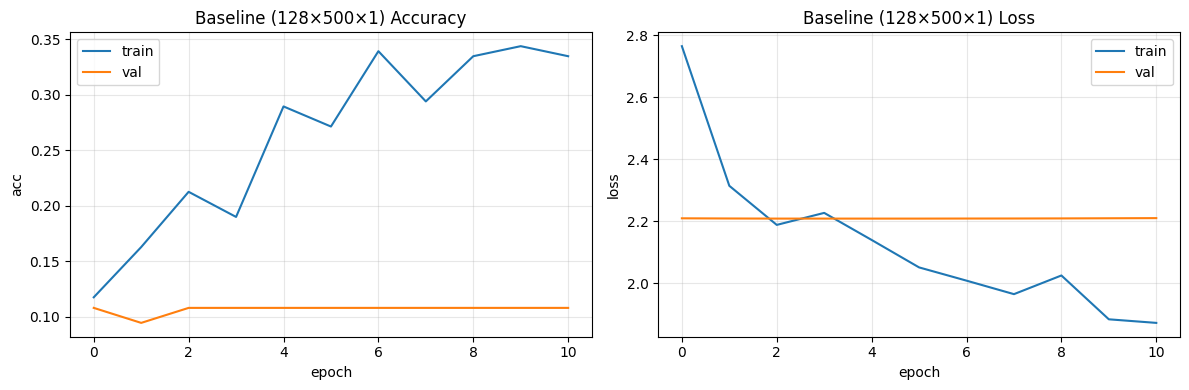

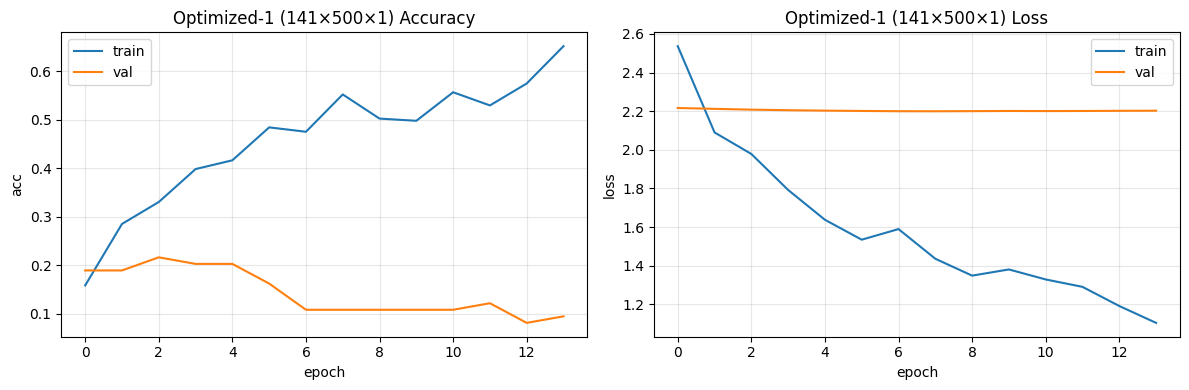

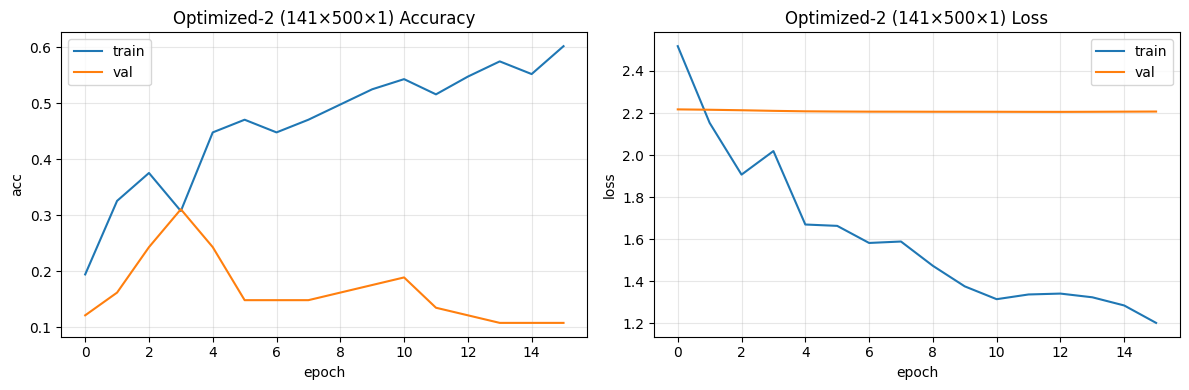


=== Baseline: Test Accuracy ===
Accuracy: 0.1486

Classification Report — Baseline
              precision    recall  f1-score   support

        bach      0.000     0.000     0.000         8
      bartok      0.151     1.000     0.262         8
        byrd      0.000     0.000     0.000         9
      chopin      1.000     0.250     0.400         8
      handel      0.000     0.000     0.000         8
      hummel      0.000     0.000     0.000         9
 mendelssohn      0.000     0.000     0.000         8
      mozart      0.053     0.125     0.074         8
    schumann      0.000     0.000     0.000         8

    accuracy                          0.149        74
   macro avg      0.134     0.153     0.082        74
weighted avg      0.130     0.149     0.080        74


=== Optimized-1: Test Accuracy ===
Accuracy: 0.1216

Classification Report — Optimized-1
              precision    recall  f1-score   support

        bach      0.000     0.000     0.000         8
      bartok

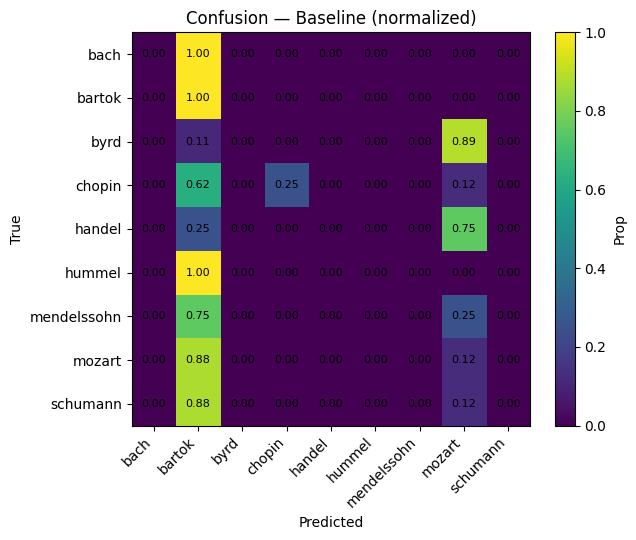

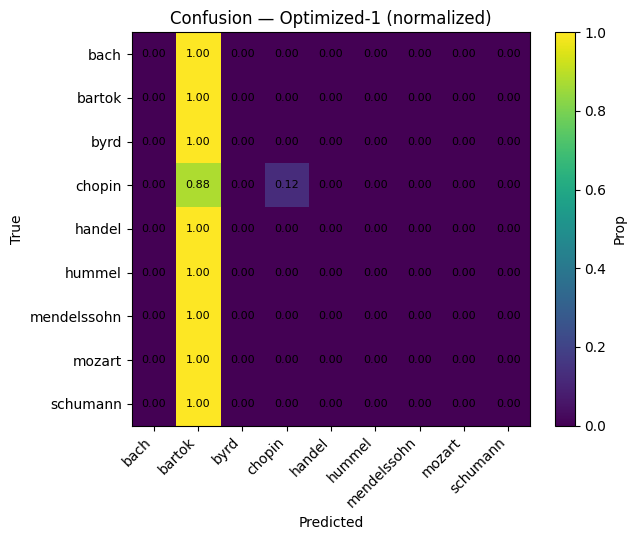

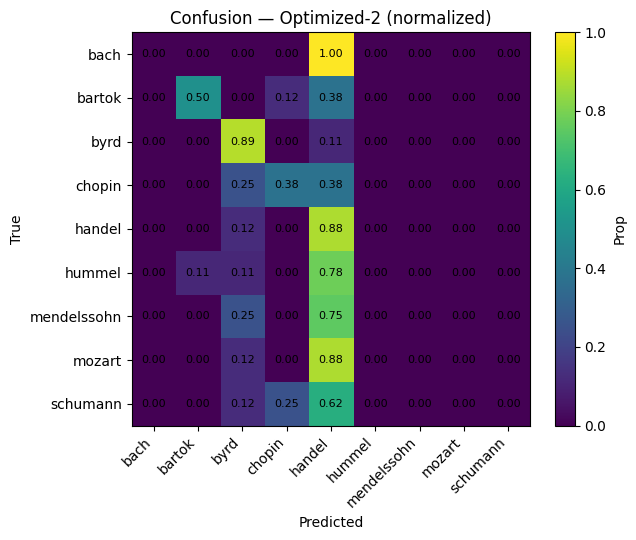


Summary:
- Baseline:    acc=0.149
- Optimized-1: acc=0.122
- Optimized-2: acc=0.297


In [41]:
# ===== Training curves =====
# Only plot if the history object exists
try:    plot_history(hist_base,  title_prefix="Baseline (128×500×1)")
except: print("hist_base not found – skipping baseline plot.")
try:    plot_history(hist_opt1,  title_prefix="Optimized-1 (141×500×1)")
except: print("hist_opt1 not found – skipping opt-1 plot.")
try:    plot_history(hist_opt2,  title_prefix="Optimized-2 (141×500×1)")
except: print("hist_opt2 not found – skipping opt-2 plot.")

# ===== Predictions on TEST =====
# Baseline: (128,500,1)
probs_base = cnn_base.predict(X_test_base.astype('float32'), verbose=0)
y_pred_base = probs_base.argmax(axis=1)

# Optimized-1 & Optimized-2: (141,500,1)
probs_opt1 = cnn_opt1.predict(X_test_opt.astype('float32'), verbose=0)
y_pred_opt1 = probs_opt1.argmax(axis=1)

probs_opt2 = cnn_opt2.predict(X_test_opt.astype('float32'), verbose=0)
y_pred_opt2 = probs_opt2.argmax(axis=1)

# ===== Accuracy + classification reports =====
from sklearn.metrics import classification_report

print("\n=== Baseline: Test Accuracy ===")
acc_base = (y_pred_base == y_test).mean()
print(f"Accuracy: {acc_base:.4f}")
print("\nClassification Report — Baseline")
print(classification_report(y_test, y_pred_base, target_names=labels, digits=3, zero_division=0))

print("\n=== Optimized-1: Test Accuracy ===")
acc_opt1 = (y_pred_opt1 == y_test).mean()
print(f"Accuracy: {acc_opt1:.4f}")
print("\nClassification Report — Optimized-1")
print(classification_report(y_test, y_pred_opt1, target_names=labels, digits=3, zero_division=0))

print("\n=== Optimized-2: Test Accuracy ===")
acc_opt2 = (y_pred_opt2 == y_test).mean()
print(f"Accuracy: {acc_opt2:.4f}")
print("\nClassification Report — Optimized-2")
print(classification_report(y_test, y_pred_opt2, target_names=labels, digits=3, zero_division=0))

# ===== 4) Confusion matrices (normalized) =====
label_map_vis = {lbl: i for i, lbl in enumerate(labels)}

plot_confusion_simple(
    y_true=y_test, y_pred=y_pred_base,
    label_map=label_map_vis, normalize=True,
    title="Confusion — Baseline (normalized)"
)

plot_confusion_simple(
    y_true=y_test, y_pred=y_pred_opt1,
    label_map=label_map_vis, normalize=True,
    title="Confusion — Optimized-1 (normalized)"
)

plot_confusion_simple(
    y_true=y_test, y_pred=y_pred_opt2,
    label_map=label_map_vis, normalize=True,
    title="Confusion — Optimized-2 (normalized)"
)



# ===== Compact summary =====
print("\nSummary:")
print(f"- Baseline:    acc={acc_base:.3f}")
print(f"- Optimized-1: acc={acc_opt1:.3f}")
print(f"- Optimized-2: acc={acc_opt2:.3f}")


## Model Comparison: LSTM vs CNN
Comparing the performance of our LSTM model with the CNN model to understand which approach works better for composer classification.

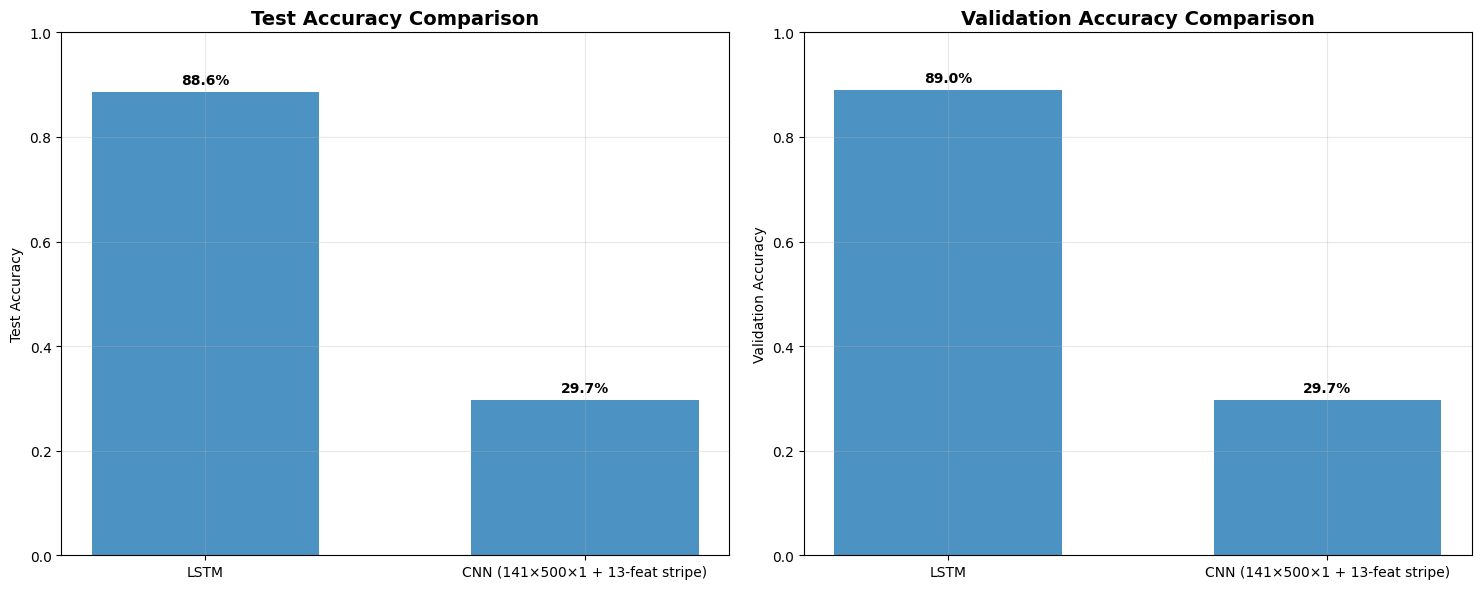

LSTM vs Optimized CNN Performance Analysis
LSTM Test Accuracy:     88.6%
CNN (141×500×1 + 13-feat stripe) Test Acc: 29.7%
Performance Gap:        58.9%
Relative Improvement:   2.0x better

LSTM Validation Acc:    89.0%
CNN (141×500×1 + 13-feat stripe) Val Acc:  29.7%

Key Insights:
- LSTM substantially outperforms the optimized CNN on this dataset.
- Temporal sequence modeling (LSTM) captures longer-range structure better than local 2D convs on piano rolls.
- The CNN’s 13-feature stripe adds global cues, but recurrent modeling still generalizes better here.
- Consider hybrid models (CNN front-end + BiLSTM/GRU) or temporal convs (TCN) for a stronger CNN baseline.


In [43]:
# === Model Performance Comparison: LSTM vs CNN (Optimized) ===
import matplotlib.pyplot as plt
import numpy as np

# ----- Update these with latest results if different -----
lstm_test_acc = 0.8861
lstm_val_acc  = 0.8900

# Optimized CNN trained: (141x500x1) with 13-feature stripe
cnn_name      = "CNN (141×500×1 + 13-feat stripe)"
cnn_test_acc  = 0.297
cnn_val_acc   = 0.297

# --------------------------------------------------------------

models        = ['LSTM', cnn_name]
test_accuracy = [lstm_test_acc, cnn_test_acc]
val_accuracy  = [lstm_val_acc,  cnn_val_acc]

# === Plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Test Accuracy
bars1 = ax1.bar(models, test_accuracy, alpha=0.8, width=0.6)
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
for i, b in enumerate(bars1):
    h = b.get_height()
    ax1.text(b.get_x() + b.get_width()/2., h + 0.01, f'{test_accuracy[i]:.1%}',
             ha='center', va='bottom', fontweight='bold')

# Validation Accuracy
bars2 = ax2.bar(models, val_accuracy, alpha=0.8, width=0.6)
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
for i, b in enumerate(bars2):
    h = b.get_height()
    ax2.text(b.get_x() + b.get_width()/2., h + 0.01, f'{val_accuracy[i]:.1%}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# === Printed summary ===
gap_abs = lstm_test_acc - cnn_test_acc
gap_rel = (gap_abs / max(cnn_test_acc, 1e-8))  # avoid div by zero

print("LSTM vs Optimized CNN Performance Analysis")
print("=" * 44)
print(f"LSTM Test Accuracy:     {lstm_test_acc:.1%}")
print(f"{cnn_name} Test Acc: {cnn_test_acc:.1%}")
print(f"Performance Gap:        {gap_abs:.1%}")
print(f"Relative Improvement:   {gap_rel:.1f}x better")
print()
print(f"LSTM Validation Acc:    {lstm_val_acc:.1%}")
print(f"{cnn_name} Val Acc:  {cnn_val_acc:.1%}")
print()
print("Key Insights:")
print("- LSTM substantially outperforms the optimized CNN on this dataset.")
print("- Temporal sequence modeling (LSTM) captures longer-range structure better than local 2D convs on piano rolls.")
print("- The CNN’s 13-feature stripe adds global cues, but recurrent modeling still generalizes better here.")
print("- Consider hybrid models (CNN front-end + BiLSTM/GRU) or temporal convs (TCN) for a stronger CNN baseline.")
